# Phosphorus lake budget

This script performs a phosphorus budget on a lake using a two-box model. This phosphorus budget is applied on past data with known TP concentrations to determine the relative contribution of external and internal phosphorus loads. This approach can be applied on monomictic lakes with a summer stratified period and a winter mixed period.

**Author**: Tomy Doda, Surface Waters - Research and Management, Eawag\
**Last update**: 21.04.2024

#### Required packages:
- numpy
- matplotlib
- pandas
- cmocean
- scipy

In [1]:
# Import the packages
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'svg.fonttype':'none', 'font.sans-serif':'Arial','font.size': 12}) # "none": to export text as text
import pandas as pd
from datetime import datetime, timezone
import math
import cmocean
from functions import *
%matplotlib widget 

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### Cases to consider:
- Pin:
    - direct measurements
    - from discharge-TP curve
- Pout:
    - direct measurements
    - from TP_epi and Qout
- Premob:
    - from avg stratif
    - from 1D thermal structure, varying over time (//SIMSTRAT)
    - from anoxic period computation (Müller et al., 2012)
    - from oxygen model
- TPsed: other method than sediment core?

#### Parameters

Methods of computation:

In [2]:
#lakename="LakeMurten"
lakename="LakeBaldegg"

In [3]:
method_Pin="curve" # Options: "obs" (compute Pin from observations of TPin), "curve" (compute Pin from Q-TPin curve)
method_epi="varying" # Options: "constant" (constant thermocline depth set during stratified period in Lake_info.csv), "varying" (thermocline depth 
# measured or modeled at different time steps)
method_anox="stratif" # Options: "stratif" (anoxic period matches stratified period), "specified" (the start of the anoxic period is specified manually in lake_info.csv),
# "estimated" (anoxic period based on empirical equation from Müller et al., (2012)).
method_netsed="Vollenweider" # Options: "Vollenweider", "Hanson" (only used in predictive model)

Time for which the phosphorus budget must be computed (if empty, use the time from the inflow data or the TP data depending which one has the lowest frequency):

In [4]:
# tdate_budget=np.array([]) # Example: tdate_budget=np.array([datetime(2024,1,1),datetime(2024,1,2),datetime(2024,1,3)]) 
# tdate_min_max=np.array([datetime(1990,1,1),datetime(2009,12,31)]) # If empty, time is the inflow data time
tdate_min_max=np.array([datetime(1990,1,1),datetime(1999,12,31)]) # If empty, time is the inflow data time
tdate_list=[tdate_min_max[0]]
while tdate_list[-1]<tdate_min_max[1]:
    month_nb=tdate_list[-1].month
    year_nb=tdate_list[-1].year
    if month_nb==12:
        month_nb=1
        year_nb+=1
    else:
        month_nb+=1
    tdate_list.append(datetime(year_nb,month_nb,1))
tdate_budget=np.array(tdate_list)

In [5]:
savefig_bool=False

## 1. Load the data

In [6]:
date_format = lambda x: pd.to_datetime(x, format="%d.%m")
df_lake=pd.read_csv("..\Data\\"+lakename+"\Lake_info.csv", sep=",",header=None,skiprows=1,usecols=[1],dtype=str) # Lake information
df_lake=df_lake.T # Transpose
df_lake.columns=["z_epi","t_stratif_start","t_stratif_end","t_anoxic_start","T_epi","T_hypo","TPsed","Kz","sigma_max","NS_max"]
df_lake.to_csv('lake_parameters.csv', sep=",",index=False,header=True) # Save the transposed dataframe
df_lake=pd.read_csv("lake_parameters.csv", sep=",",header=0,parse_dates=["t_stratif_start","t_stratif_end","t_anoxic_start"],date_parser=date_format) # Load it again to have the correct date format 
Kz=df_lake["Kz"][0]
TPsed=df_lake["TPsed"][0]

In [7]:
df_hypso=pd.read_csv("..\Data\\"+lakename+"\Hypsometry.csv", sep=",",header=0,names=["z_hypso","A_hypso"]) # Hypsometry
z_hypso=df_hypso["z_hypso"].to_numpy()
df_lake["z_max"]=np.max(z_hypso)
A_hypso=df_hypso["A_hypso"].to_numpy()
A0=A_hypso[z_hypso==0]
V_hypso=np.concatenate((np.mean([A_hypso[1:],A_hypso[:-1]],axis=0)*(z_hypso[1:]-z_hypso[:-1]),np.array([0]))) # Volume of each layer [m3]
V_lake=np.nansum(V_hypso) # [m3]
z_mean=V_lake/A0 # [m]

In [8]:
date_format = lambda x: pd.to_datetime(x, format='%d.%m.%Y')

simstrat_file="..\Data\\"+lakename+"\\"+lakename+"_T_SIMSTRAT.dat"
df_inflows=pd.read_csv("..\Data\\"+lakename+"\Inflows.csv", sep=",",parse_dates=["Date"],date_parser=date_format) # Inflows
df_outflows=pd.read_csv("..\Data\\"+lakename+"\Outflows.csv", sep=",",parse_dates=["Date"],date_parser=date_format) # Outflows
df_TP=pd.read_csv("..\Data\\"+lakename+"\TP.csv", sep=",") # TP concentrations
dates_TP=np.array([datetime.strptime(datestr,"%d/%m/%Y") for datestr in df_TP.columns[1:]]) # Dates with measured TP
tnum_TP=np.array([d.replace(tzinfo=timezone.utc).timestamp() for d in dates_TP])

In [9]:
if method_Pin=="curve":
    df_Q=pd.read_csv("..\Data\\"+lakename+"\Discharges.csv", sep=",",parse_dates=["Date"],date_parser=date_format) 
    tnum_Q=df_Q["Date"].to_numpy().astype('datetime64[s]').astype(np.int64)
    tdate_Q=df_Q["Date"].to_numpy().astype('datetime64[s]').astype(datetime)
    Qval=df_Q.values[:,np.arange(1,len(df_Q.columns),1)].astype(float)

Set the time for the budget:

In [10]:
if not list(tdate_budget): # Empty: take the time from the lowest frequency between inflow data and TP data
    if method_Pin=="obs":
        dt_inflows=np.nanmean(np.diff(df_inflows["Date"].to_numpy().astype('datetime64[s]').astype(np.int64)))
        dt_TP=np.nanmean(np.diff(tnum_TP))
        ind_low_freq=np.argmax(np.array([dt_inflows,dt_TP])) # Lowest frequency
        if ind_low_freq==0: # Take inflows time
            tdate_budget=df_inflows["Date"].to_numpy().astype('datetime64[s]').astype(datetime)
        else: # Take TP time
            tdate_budget=dates_TP
        
        if list(tdate_min_max): # Not empty
            tdate_budget=tdate_budget[np.logical_and(tdate_budget>tdate_min_max[0],tdate_budget<tdate_min_max[1])]
    else:
        raise Exception("Time values of the P budget must be specified")

In [11]:
tnum_budget=np.array([dateval.replace(tzinfo=timezone.utc).timestamp() for dateval in tdate_budget])

Compute the thermocline depth at each TP measurement timestep (from constant thermocline or from measured/modelled temperature):

In [12]:
if method_epi=="constant":
    tdate_start=df_lake["t_stratif_start"].to_numpy().astype('datetime64[s]').astype(datetime)[0]
    tdate_end=df_lake["t_stratif_end"].to_numpy().astype('datetime64[s]').astype(datetime)[0]
    hepi_TP=compute_hepi_constant(dates_TP,tdate_start,tdate_end,hepi=df_lake["z_epi"][0],zmax=df_lake["z_max"][0]) # At time steps of TP measurements
    hepi_budget=compute_hepi_constant(tdate_budget,tdate_start,tdate_end,hepi=df_lake["z_epi"][0],zmax=df_lake["z_max"][0]) # At time steps of P budget
else:
    tnum_T, depth_T, tempval=extract_simstrat_T(simstrat_file) # Extract Simstrat temperature data
    bool_period=np.logical_and(tnum_T>=tnum_budget[0],tnum_T<=tnum_budget[-1]) # Select period of interest
    hepi_TP,hepi_T=compute_hepi_varying(tnum_TP,tnum_T[bool_period],depth_T,tempval[:,bool_period],zmax=df_lake["z_max"][0]) # At time steps of TP measurements
    hepi_budget,_=compute_hepi_varying(tnum_budget,tnum_T[bool_period],depth_T,tempval[:,bool_period],zmax=df_lake["z_max"][0]) # At time steps of P budget
    
Vepi=np.full(len(hepi_budget),np.nan)
Atherm=np.full(len(hepi_budget),np.nan)
for kt in range(len(hepi_budget)):
    Vepi[kt]=np.nansum(V_hypso[z_hypso<=hepi_budget[kt]])
    Atherm[kt]=A_hypso[np.where(z_hypso>=hepi_budget[kt])[0][0]]
hepi_model=Vepi/A0 # Thermocline depth for a box of the same volume as the epilimnion

## 2. Compute the terms of the mass balance

#### Phosphorus load from inflows ($P_{\rm in}$)

In [13]:
tnum_inflows=df_inflows["Date"].to_numpy().astype('datetime64[s]').astype(np.int64)
Q_inflows=df_inflows.values[:,np.arange(1,len(df_inflows.columns),2)].astype(float)
TP_inflows=df_inflows.values[:,np.arange(2,len(df_inflows.columns),2)].astype(float)

In [14]:
if method_Pin=="obs":
    Pin=compute_river_load_from_obs(tnum_inflows,Q_inflows,TP_inflows,tnum_budget) # [tons-P yr-1]
else: # From Q-TP curve
    Pin,Qin_curve,tnum_budget2=compute_river_load_from_curve(Q_inflows,TP_inflows,tnum_Q,Qval,tnum_budget,method="power",calculation="average") # [tons-P yr-1]
    Pin=np.concatenate((Pin,np.array([np.nan])),axis=0) # Add a nan value at the end
    Qin_curve=np.concatenate((Qin_curve,np.array([np.nan])),axis=0) # Add a nan value at the end

F:\Backup_Tomy\Data\Phosphorus\Model\phosphorus_model\Scripts\functions.py:83: RuntimeWarning: divide by zero encountered in log
  TPval[:,kin]=np.exp(np.polyval(param,np.log(Qval[Qval[:,kin]>=0,kin])))
C:\Users\dodatomy\Anaconda3\envs\envass\lib\site-packages\numpy\lib\polynomial.py:779: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv
F:\Backup_Tomy\Data\Phosphorus\Model\phosphorus_model\Scripts\functions.py:81: RuntimeWarning: divide by zero encountered in log
  regres= linregress(np.log(Qcurve[bool_keep,kin]),np.log(TPcurve[bool_keep,kin]))
C:\Users\dodatomy\Anaconda3\envs\envass\lib\site-packages\numpy\lib\function_base.py:2698: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


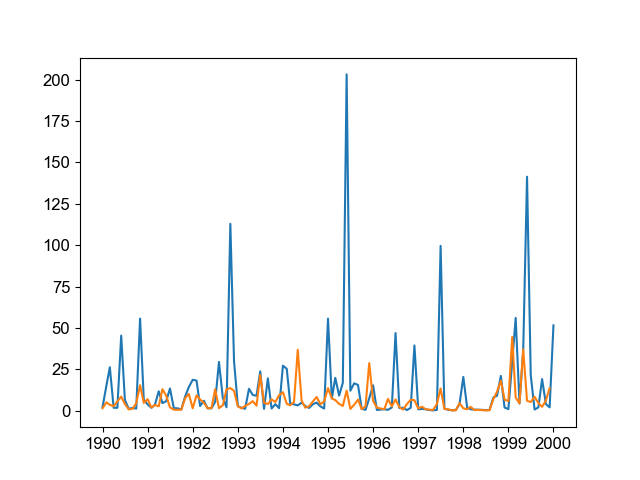

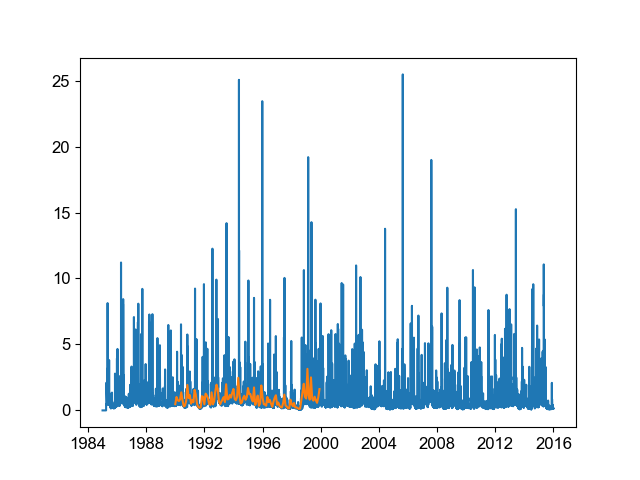

In [15]:
if method_Pin=="curve":
    plt.figure()
    Pin_obs=compute_river_load_from_obs(tnum_inflows,Q_inflows,TP_inflows,tnum_budget) # [tons-P yr-1]
    plt.plot(tdate_budget,Pin_obs)
    plt.plot(tdate_budget,Pin)
    
    plt.figure()
    #plt.plot(df_inflows["Date"],np.nansum(Q_inflows,axis=1))
    plt.plot(tdate_Q,np.nansum(Qval,axis=1))
    plt.plot(tdate_budget,Qin_curve)

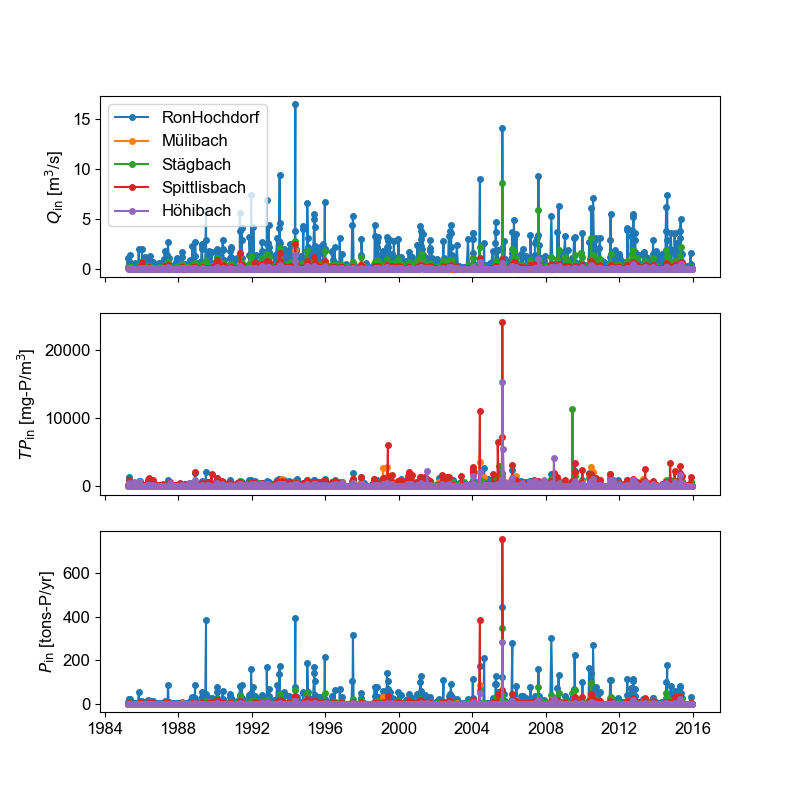

In [16]:
fig,ax=plt.subplots(3,1,figsize=(8,8),sharex=True)
legname=[]
for kriver in range(Q_inflows.shape[1]):
    column_name=df_inflows.columns[2*kriver+1]
    legname.append(column_name[2:column_name.find(" [m3")])
    ax[0].plot(df_inflows["Date"],Q_inflows[:,kriver],'.-',markersize=8)
    ax[1].plot(df_inflows["Date"],TP_inflows[:,kriver],'.-',markersize=8)
    ax[2].plot(df_inflows["Date"],Q_inflows[:,kriver]*TP_inflows[:,kriver]*86400*365*1e-9,'.-',markersize=8)
ax[0].set_ylabel('$Q_{\\rm in}$ [m$^3$/s]')
ax[1].set_ylabel('$TP_{\\rm in}$ [mg-P/m$^3$]')
ax[2].set_ylabel('$P_{\\rm in}$ [tons-P/yr]')
ax[0].legend(legname)

# Save figure
if savefig_bool:
    fig.savefig("../Figures/Pin.png",dpi=400)
    fig.savefig("../Figures/Pin.svg")
    print('Figure saved!')

#### Phosphorus load in outflows ($P_{\rm out}$)

In [17]:
tnum_outflows=df_outflows["Date"].to_numpy().astype('datetime64[s]').astype(np.int64)
Q_outflows=df_outflows.values[:,np.arange(1,len(df_outflows.columns),2)].astype(float)
TP_outflows=df_outflows.values[:,np.arange(2,len(df_outflows.columns),2)].astype(float)

In [18]:
Pout=compute_river_load_from_obs(tnum_outflows,Q_outflows,TP_outflows,tnum_budget) # [tons-P yr-1]

#### Phosphorus in epilimnion and hypolimnion ($TP_{\rm epi}$, $TP_{\rm hypo}$)

In [19]:
depthval=df_TP["Depth [m]"].values
TPepi,TPhypo=compute_TP_2boxes(depthval,df_TP.values[:,1:],hepi_TP)
# Temperature in epilimnion and hypolimnion:
if method_epi=="varying":
    T_epi,T_hypo=compute_TP_2boxes(depth_T,tempval[:,bool_period],hepi_T)
    T_epi=np.interp(tnum_TP,tnum_T[bool_period],T_epi)
    T_hypo=np.interp(tnum_TP,tnum_T[bool_period],T_hypo)
else:
    T_epi=np.full(len(tnum_TP),df_lake["T_epi"][0]) # Annual average
    T_hypo=np.full(len(tnum_TP),df_lake["T_hypo"][0])
# Interpolation at the chosen time steps 
TPepi_budget=np.interp(tnum_budget,tnum_TP,TPepi)
TPhypo_budget=np.interp(tnum_budget,tnum_TP,TPhypo)
T_epi_budget=np.interp(tnum_budget,tnum_TP,T_epi)
T_hypo_budget=np.interp(tnum_budget,tnum_TP,T_hypo)

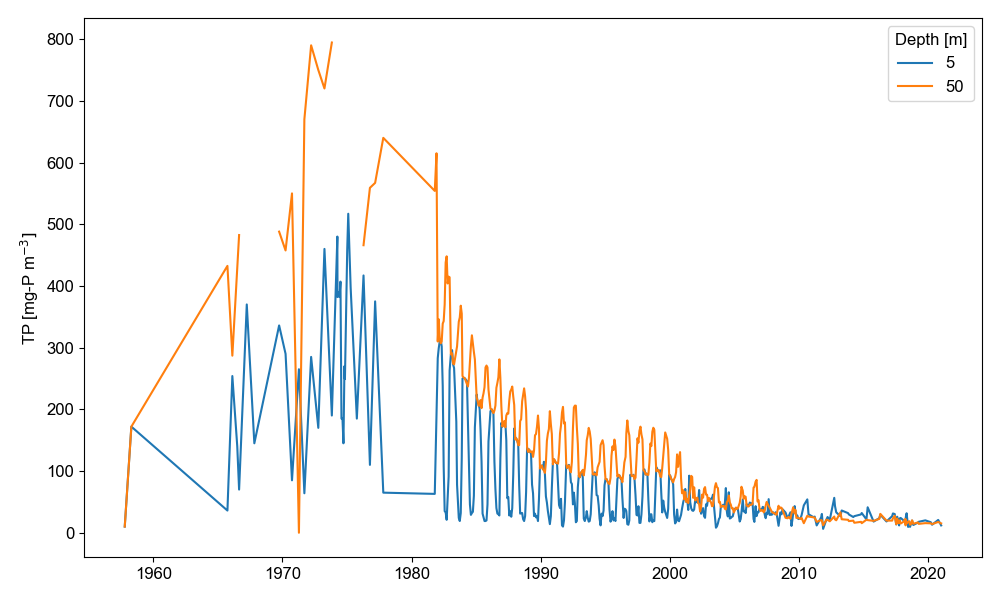

In [20]:
plt.figure(figsize=(10,6))
depth_select=[5,50]
for d in depth_select:
    plt.plot(dates_TP,df_TP.values[np.where(depthval==d)[0][0],1:])
plt.gca().set_ylabel('TP [mg-P m$^{-3}]$')
lg=plt.legend(depth_select)
lg.set_title('Depth [m]')
plt.gcf().set_tight_layout(True)

#### Phosphorus vertical flux ($P_{\rm z}$), positive upwards

In [21]:
Pz=2*Kz*Atherm*(TPhypo_budget-TPepi_budget)/z_mean*86400*365*1e-9 # [tons-P yr-1]

#### Remobilization flux ($P_{\rm remob}$) from empirical formulae

In [22]:
if method_anox=="stratif":
    bool_anox=hepi_budget<df_lake["z_max"][0]
elif method_anox=="specified":
    bool_anox=compute_anoxia_dates(tdate_budget,df_lake["t_anoxic_start"].to_numpy().astype('datetime64[s]').astype(datetime)[0],hepi_budget,df_lake["z_max"][0]) 
else:
    if method_epi=="varying":
        # Determine stratified periods accurately
        tnum_stratif=compute_stratified_periods(tnum_T[bool_period],hepi_T,df_lake["z_max"][0])
    else:
        all_years=np.array([tdate.year for tdate in tdate_budget])
        unique_years=np.unique(all_years)
        tnum_stratif=np.full((2,len(unique_years)),np.nan)
        for ky in range(len(unique_years)):
            tnum_stratif[:,ky]=np.array([datetime(unique_years[ky],tdate_start.month,tdate_start.day).replace(tzinfo=timezone.utc).timestamp(),\
                               datetime(unique_years[ky],tdate_end.month,tdate_end.day).replace(tzinfo=timezone.utc).timestamp()])
    bool_anox,ndays_to_anox,tstart_anox=compute_anoxia_red(tnum_budget,hepi_model,z_mean,tnum_stratif=tnum_stratif)

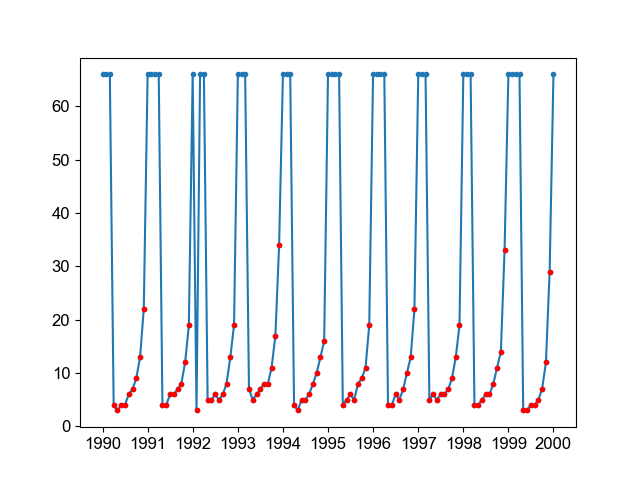

In [23]:
plt.figure()
plt.plot(tdate_budget,hepi_budget,'.-')
plt.plot(tdate_budget[bool_anox],hepi_budget[bool_anox],'r.')

In [24]:
Premob_Hanson=np.full(Pz.shape,0)
Premob_Hanson[bool_anox]=compute_remobilization_Hanson(T_hypo_budget[bool_anox],TPsed,Atherm[bool_anox]) # [tons-P yr-1]

In [25]:
Premob_Nurnberg=np.full(Pz.shape,0)
Premob_Nurnberg[bool_anox]=compute_remobilization_Nurnberg(TPsed,Atherm[bool_anox]) # [tons-P yr-1]

In [26]:
Premob_Carter=np.full(Pz.shape,0)
Premob_Carter[bool_anox]=compute_remobilization_Carter(TPepi_budget[bool_anox],Atherm[bool_anox]) # [tons-P yr-1]

In [27]:
# fig,ax=plt.subplots(2,1,figsize=(8,5),sharex=True)

# ax[0].plot(tdate_budget,Premob_Hanson,'.-')
# ax[0].plot(tdate_budget,Premob_Nurnberg,'.-')
# ax[0].plot(tdate_budget,Premob_Carter,'.-')
# ax[0].plot(tdate_budget,Pin,'k.-')
# ax[0].legend(["$P_{\\rm remob,Hansen}$","$P_{\\rm remob,Nürnberg}$","$P_{\\rm remob,Carter}$","$P_{\\rm in}$"])
# ax[0].set_ylabel('$P$ [tons-P/yr]')

# ratio_val=np.array([list(Premob_Hanson/(Pin+Premob_Hanson)),list(Premob_Nurnberg/(Pin+Premob_Nurnberg)),list(Premob_Carter/(Pin+Premob_Carter))])
# ratio_max=np.nanmax(ratio_val,axis=0)
# ratio_min=np.nanmin(ratio_val,axis=0)
# ax[1].plot(tdate_budget,ratio_val[0,:],'.')
# ax[1].plot(tdate_budget,ratio_val[1,:],'.')
# ax[1].plot(tdate_budget,ratio_val[2,:],'.')
# ax[1].plot(tdate_budget,ratio_max,'--k')
# ax[1].plot(tdate_budget,ratio_min,'--k')
# ax[1].plot([tdate_budget[0],tdate_budget[-1]],[0.5,0.5],':r')
# ax[1].set_ylim(0,1)
# ax[1].set_ylabel('$P_{\\rm remob}/(P_{\\rm in}+P_{\\rm remob})$')

#### Remobilization flux ($P_{\rm remob}$) from mass balance

In [28]:
dTPepi_dt,dTPhypo_dt=compute_changes_TP(tnum_TP,TPepi,TPhypo,tnum_budget) # [mg-P.m-3.s-1]
dTPepi_dt=dTPepi_dt*84600*365*1e-9 # [tons-P.m-3.yr-1]
dTPhypo_dt=dTPhypo_dt*84600*365*1e-9 # [tons-P.m-3.yr-1]

Vepi_TP=np.full(len(hepi_TP),np.nan)
for kt in range(len(hepi_TP)):
    Vepi_TP[kt]=np.nansum(V_hypso[z_hypso<=hepi_TP[kt]])
dMepi_dt,dMhypo_dt=compute_changes_TP(tnum_TP,TPepi*Vepi_TP,TPhypo*(V_lake-Vepi_TP),tnum_budget) # [mg-P.s-1]
dMepi_dt=dMepi_dt*84600*365*1e-9 # [tons-P.yr-1]
dMhypo_dt=dMhypo_dt*84600*365*1e-9 # [tons-P.yr-1]

In [29]:
dVepi_model=np.diff(hepi_model)*A0
dm_model=dVepi_model*TPhypo_budget[:-1]
dm_model[dVepi_model<0]=dVepi_model[dVepi_model<0]*TPepi_budget[:-1][dVepi_model<0] # [mg-P]
dm_model=dm_model*1e-9 # [tons-P]
dmdt=np.concatenate((np.array([0]),dm_model/np.diff(tnum_budget)*84600*365)) # [tons-P.yr-1]
# Remove start of stratification:
dmdt[np.where(hepi_model[:-1]==z_mean)[0]+1]=0
# Remove start of mixing:
dmdt[np.where(hepi_model[:-1]==z_mean)[0]]=0

In [30]:
P_GrossSed=Pin-Pout+Pz+dmdt-dMepi_dt
# P_GrossSed=Pin-Pout+Pz-A0*hepi_model*dTPepi_dt


In [31]:
P_NetSed=P_GrossSed-Pz-dmdt-dMhypo_dt
# P_NetSed=P_GrossSed-Pz-A0*(z_mean-hepi_model)*dTPhypo_dt
#P_NetSed[P_NetSed<0]=0

In [32]:
Premob_balance=P_GrossSed-P_NetSed # = Pz+A0*(z_mean-hepi_model)*dTPhypo_dt
Premob_balance_corr=np.copy(Premob_balance)
Premob_balance_corr[Premob_balance_corr<0]=0
Premob_balance_corr[Premob_balance_corr>50]=np.nan

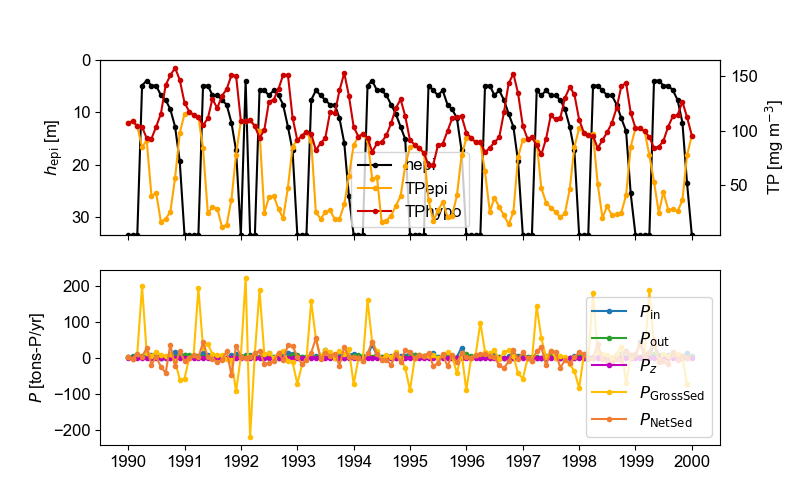

In [33]:
fig,ax=plt.subplots(2,1,figsize=(8,5),sharex=True)
colplots=plt.get_cmap('tab10')
col_yellow=(1,190/255,0)
col_orange=(240/255,125/255,50/255)

p1,=ax[0].plot(tdate_budget,hepi_model,'k.-')
ax_right=ax[0].twinx()
p2,=ax_right.plot(tdate_budget,TPepi_budget,'.-',color='orange')
p3,=ax_right.plot(tdate_budget,TPhypo_budget,'.-',color=(0.8,0,0))
ax[0].legend([p1,p2,p3],["hepi","TPepi","TPhypo"])
ax[0].set_ylabel('$h_{\\rm epi}$ [m]')
ax[0].set_ylim(0,z_mean)
ax[0].invert_yaxis()
ax_right.set_ylabel('TP [mg m$^{-3}$]')

ax[1].plot(tdate_budget,Pin,'.-',color=colplots(0))
ax[1].plot(tdate_budget,Pout,'.-',color=colplots(2))
ax[1].plot(tdate_budget,Pz,'.-',color='m')
ax[1].plot(tdate_budget,P_GrossSed,'.-',color=col_yellow)
ax[1].plot(tdate_budget,P_NetSed,'.-',color=col_orange)
ax[1].set_ylabel('$P$ [tons-P/yr]')
ax[1].legend(["$P_{\\rm in}$","$P_{\\rm out}$","$P_{z}$","$P_{\\rm GrossSed}$","$P_{\\rm NetSed}$"])

C:\Users\dodatomy\AppData\Local\Temp\ipykernel_20492\1835250264.py:24: RuntimeWarning: All-NaN slice encountered
  ratio_max2=np.nanmax(ratio_val2[:-1,:],axis=0)
C:\Users\dodatomy\AppData\Local\Temp\ipykernel_20492\1835250264.py:25: RuntimeWarning: All-NaN slice encountered
  ratio_min2=np.nanmin(ratio_val2[:-1,:],axis=0)


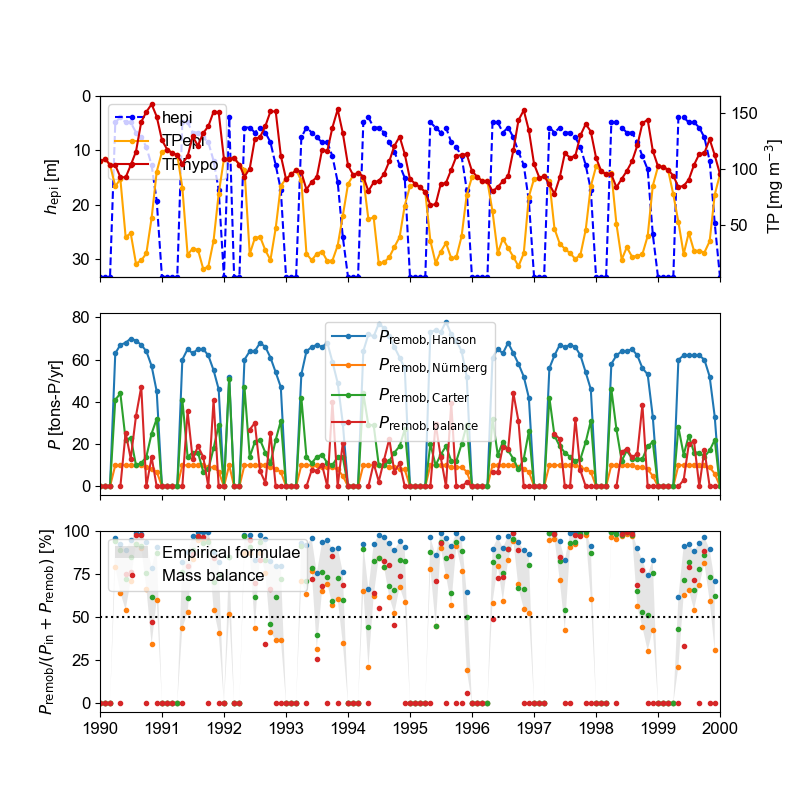

In [34]:
fig,ax=plt.subplots(3,1,figsize=(8,8),sharex=True)

p1,=ax[0].plot(tdate_budget,hepi_model,'b.--')
ax_right=ax[0].twinx()
p2,=ax_right.plot(tdate_budget,TPepi_budget,'.-',color='orange')
p3,=ax_right.plot(tdate_budget,TPhypo_budget,'.-',color=(0.8,0,0))
ax[0].legend([p1,p2,p3],["hepi","TPepi","TPhypo"],loc="upper left")
ax[0].set_ylabel('$h_{\\rm epi}$ [m]')
ax[0].set_ylim(0,z_mean)
ax[0].invert_yaxis()
ax[0].set_xlim(tdate_budget[0],tdate_budget[-1])
ax_right.set_ylabel('TP [mg m$^{-3}$]')

#ax[1].plot(tdate_budget,Pin,'k.--')
ax[1].plot(tdate_budget,Premob_Hanson,'.-')
ax[1].plot(tdate_budget,Premob_Nurnberg,'.-')
ax[1].plot(tdate_budget,Premob_Carter,'.-')
# ax[1].plot(tdate_budget,Premob_balance,'.-')
ax[1].plot(tdate_budget,Premob_balance_corr,'.-')
ax[1].legend(["$P_{\\rm remob,Hanson}$","$P_{\\rm remob,Nürnberg}$","$P_{\\rm remob,Carter}$","$P_{\\rm remob,balance}$"])
ax[1].set_ylabel('$P$ [tons-P/yr]')

ratio_val2=np.array([list(Premob_Hanson/(Pin+Premob_Hanson)),list(Premob_Nurnberg/(Pin+Premob_Nurnberg)),list(Premob_Carter/(Pin+Premob_Carter)),list(Premob_balance_corr/(Pin+Premob_balance_corr))])
ratio_max2=np.nanmax(ratio_val2[:-1,:],axis=0)
ratio_min2=np.nanmin(ratio_val2[:-1,:],axis=0)

ax[2].plot(tdate_budget,ratio_val2[0,:]*100,'.')
ax[2].plot(tdate_budget,ratio_val2[1,:]*100,'.')
ax[2].plot(tdate_budget,ratio_val2[2,:]*100,'.')

#ax[2].plot(tdate_budget,ratio_max2*100,'-k')
#ax[2].plot(tdate_budget,ratio_min2*100,'-k')
p4=ax[2].fill_between(tdate_budget,ratio_min2*100,ratio_max2*100,\
                   facecolor=(0.5,0.5,0.5),edgecolor=None,alpha=0.2)
p5,=ax[2].plot(tdate_budget,ratio_val2[3,:]*100,'.')
ax[2].plot([tdate_budget[0],tdate_budget[-1]],[50,50],':k')
ax[2].set_ylim(-5,100)
ax[2].legend([p4,p5],["Empirical formulae","Mass balance"],loc='upper left')
ax[2].set_ylabel('$P_{\\rm remob}/(P_{\\rm in}+P_{\\rm remob})$ [%]')

# Save figure
if savefig_bool:
    fig.savefig("../Figures/Premob_"+lakename+"_"+method_epi+".png",dpi=400)
    fig.savefig("../Figures/Premob_"+lakename+"_"+method_epi+".svg")
    print('Figure saved!')

## 3. Test predictive mass balance model

In [35]:
if method_Pin=="obs":
    Qin_budget=np.interp(tnum_budget,tnum_inflows,np.nansum(Q_inflows,axis=1)) # Assumption: Qout=Qin
else:
    Qin_budget=Qin_curve # Assumption: Qout=Qin

In [36]:
if type(df_lake["sigma_max"][0])==float:
    sigma_max=df_lake["sigma_max"][0]
else:
    sigma_max=np.nan
    
if type(df_lake["NS_max"][0])==float:
    P_NS_max=df_lake["NS_max"][0] 
else:
    P_NS_max=np.nan


tnum_predict,TPepi_predict,TPepi_range,TPhypo_predict,TPhypo_range,P_fluxes,param=predict_TP_model(tnum_budget,bool_anox,Pin,Qin_budget,hepi_budget,TPepi_budget[0],TPhypo_budget[0],TPsed,\
                                                                                   z_hypso,A_hypso,T_hypo_budget,T_epi_budget,sigma_max=sigma_max,P_NS_max=P_NS_max,\
                                                                                             method_sed=method_netsed,method_remob="Nurnberg")

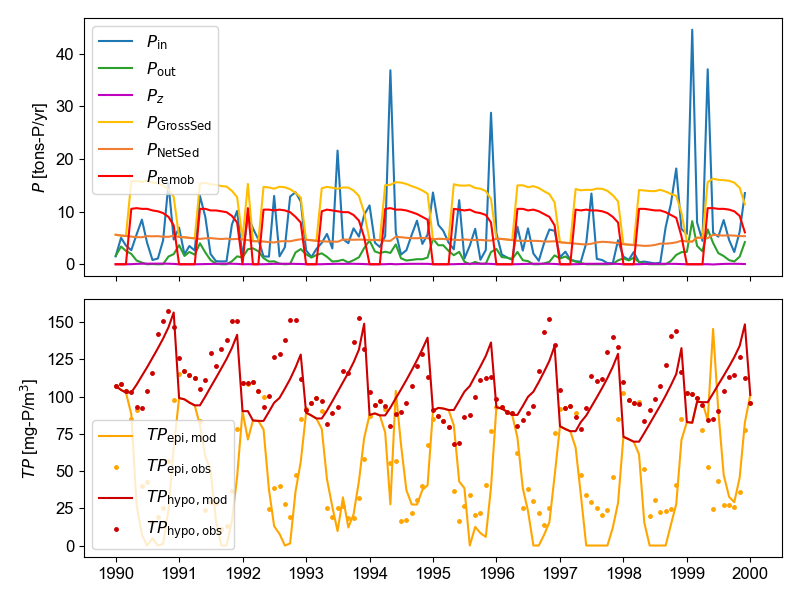

In [37]:
fig,ax=plt.subplots(2,1,figsize=(8,6),sharex=True)
tdate_predict=np.array([datetime.utcfromtimestamp(tnum) for tnum in tnum_predict])

ax[0].plot(tdate_budget,P_fluxes["Pin"],'-',color=colplots(0))
ax[0].plot(tdate_budget,P_fluxes["Pout_epi"],'-',color=colplots(2))
ax[0].plot(tdate_budget,P_fluxes["Pz"],'-',color='m')
ax[0].plot(tdate_budget,P_fluxes["Premob"]+P_fluxes["Pnet_sed"],'-',color=col_yellow)
ax[0].plot(tdate_budget,P_fluxes["Pnet_sed"],'-',color=col_orange)
ax[0].plot(tdate_budget,P_fluxes["Premob"],'-',color='r')
ax[0].set_ylabel('$P$ [tons-P/yr]')
ax[0].legend(["$P_{\\rm in}$","$P_{\\rm out}$","$P_{z}$","$P_{\\rm GrossSed}$","$P_{\\rm NetSed}$","$P_{\\rm remob}$"])

p1,=ax[1].plot(tdate_predict,TPepi_predict,'-',color='orange')
# ax[1].fill_between(np.concatenate((tdate_predict,np.flip(tdate_predict))),np.concatenate((TPepi_range[0,:],np.flip(TPepi_range[1,:]))),\
#                    facecolor='orange',edgecolor=None,alpha=0.2)
p2,=ax[1].plot(tdate_budget,TPepi_budget,'.',color='orange',markersize=5)
p3,=ax[1].plot(tdate_predict,TPhypo_predict,'-',color=(0.8,0,0))
# ax[1].fill_between(np.concatenate((tdate_predict,np.flip(tdate_predict))),np.concatenate((TPhypo_range[0,:],np.flip(TPhypo_range[1,:]))),\
#                    facecolor=(0.8,0,0),edgecolor=None,alpha=0.2)
p4,=ax[1].plot(tdate_budget,TPhypo_budget,'.',color=(0.8,0,0),markersize=5)
ax[1].set_ylabel('$TP$ [mg-P/m$^3$]')
ax[1].legend([p1,p2,p3,p4],["$TP_{\\rm epi,mod}$","$TP_{\\rm epi,obs}$","$TP_{\\rm hypo,mod}$","$TP_{\\rm hypo,obs}$"])

fig.set_tight_layout(True)

In [38]:
# Save figure
if savefig_bool:
    fig.savefig("../Figures/TP_predict_long_"+method_Pin+".png",dpi=400)
    fig.savefig("../Figures/TP_predict__long"+method_Pin+".svg")
    print('Figure saved!')